In [1]:
from drawing_bot_api.trajectory_optimizer.simulator import Simulator, ExponentialDecaySimulator
from drawing_bot_api.trajectory_optimizer.shape_generator import ShapeGenerator
from drawing_bot_api.commands import DrawingBot
import numpy as np
import matplotlib.pyplot as plt
from drawing_bot_api.trajectory_optimizer.image_processor import ImageProcessor
from drawing_bot_api.trajectory_optimizer.utils import Scheduler
from IPython.display import clear_output
import signal

DEBUG_MODE = True

%matplotlib agg

np.set_printoptions(threshold=np.inf)

2025-01-28 07:41:11.950383: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [3]:
drawing_bot = DrawingBot()
simulator = Simulator()
compensator = ExponentialDecaySimulator()
shape_generator = ShapeGenerator()
image_processor = ImageProcessor()

Unit set to "mm".


In [4]:
def plot_graph(data, labels, scale='linear'):
    plt.yscale(scale)
    for _i in range(len(data)):
        plt.plot(data[_i], label=labels[_i])
    plt.legend(bbox_to_anchor=(1, 1.15), ncol=3)  
    plt.show() 

In [5]:
def get_trajectory():
    for shape in shape_generator(seed=1):
        drawing_bot.add_shape(shape)
    trajectory = np.array(drawing_bot._get_all_points())
    template = drawing_bot.plot(training_mode=True, points=trajectory)
    drawing_bot.shapes.clear()
    return trajectory, template

In [6]:
def get_parameters(reference_parameters):
    pass

In [7]:
def test_parameters(parameters, trajectory, template):
    compensated_trajectory, _ = compensator(trajectory, type='fourier', parameters=parameters) #, tanh_scaling=[4])
    simulated_trajectory = simulator(compensated_trajectory)
    drawing = drawing_bot.plot(training_mode=True, points=simulated_trajectory)
    reward = image_processor(template, drawing, save_images=False)
    return reward, drawing

In [8]:
KEEP_SETS = 3
NEW_BRANCHES_PER_GEN = 1
GENERATION_SIZE = 8
NUM_OF_PARAMETERS = 8
GENERATIONS = 500

SIGMA_BASE_INIT = 1.5
SIGMA_DECAY_INIT = 0.98

SIGMA_SWITCH_GENERATIION = 1
SIGMA_BASE_SWITCH = 0.15
SIGMA_DECAY_SWITCH = 1

FIXED_GAIN = 1

generation: 0	best_set: [0.23299524 0.06406    0.54984377 0.6622291  0.12209072 0.93165924
 0.28797811 0.37428366]	reward: 0.7160694353731436 / 0.7488561870356298	sigma: 1.5
generation: 1	best_set: [0.23299524 0.06406    0.54984377 0.6622291  0.12209072 0.93165924
 0.28797811 0.37428366]	reward: 0.7160694353731436 / 0.7488561870356298	sigma: 0.15
generation: 2	best_set: [ 0.22984183 -0.22903845  0.66859266  0.74640389  0.11447157  0.78986903
  0.41957197  0.37965912]	reward: 0.7548261133220191 / 0.7488561870356298	sigma: 0.15
generation: 3	best_set: [ 0.68767029 -1.24704535 -0.33075932 -0.04249949 -0.21675349  0.54827157
  0.35390967  0.4638062 ]	reward: 0.8065110447047923 / 0.7488561870356298	sigma: 0.15
generation: 4	best_set: [ 0.68767029 -1.24704535 -0.33075932 -0.04249949 -0.21675349  0.54827157
  0.35390967  0.4638062 ]	reward: 0.8065110447047923 / 0.7488561870356298	sigma: 0.15
generation: 5	best_set: [ 0.68767029 -1.24704535 -0.33075932 -0.04249949 -0.21675349  0.54827157
  0.3

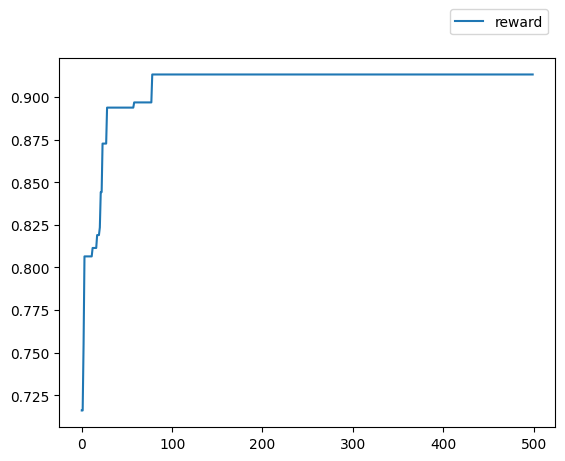

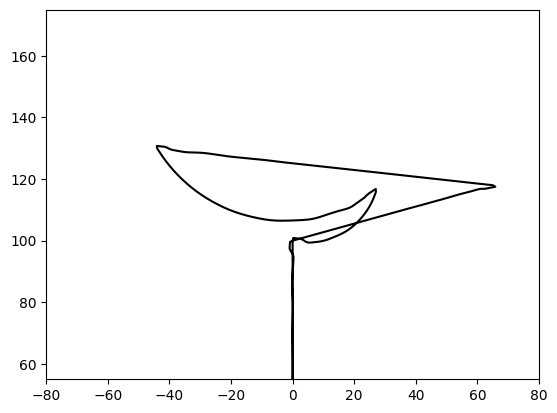

<Figure size 600x400 with 0 Axes>

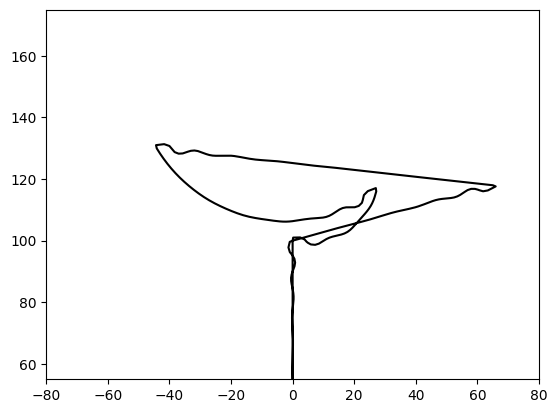

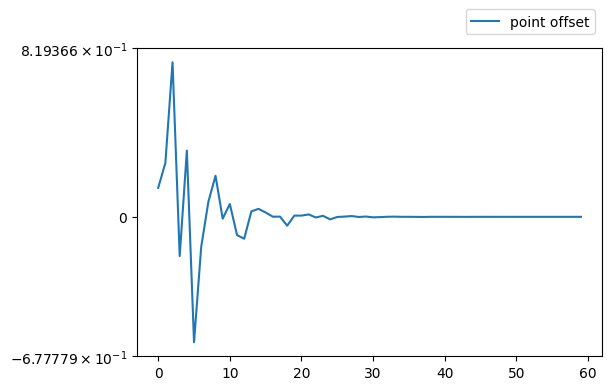

In [9]:
best_set = None
parameters = np.random.random((GENERATION_SIZE, NUM_OF_PARAMETERS))
sigma_schedule = Scheduler(SIGMA_BASE_INIT, SIGMA_DECAY_INIT)
reward_history = []
trajectory, template = get_trajectory()

simulated_template = simulator(trajectory)
uncompensated_drawing = drawing_bot.plot(training_mode=True, points=simulated_template)
template_reward = image_processor(template, uncompensated_drawing, save_images=False)

for generation_index in range(GENERATIONS):
    signal.alarm(5)

    try:
        sigma = sigma_schedule()

        if generation_index % SIGMA_SWITCH_GENERATIION == SIGMA_SWITCH_GENERATIION-1:
            sigma_schedule = Scheduler(SIGMA_BASE_SWITCH, SIGMA_DECAY_SWITCH)

        rewards = []
        drawings = []
        for set in parameters:
            reward, drawing = test_parameters(set, trajectory, template)
            rewards.append(reward)
            drawings.append(drawing)

        reward_history.append(max(rewards))
        
        # Get indices of the three best sets
        rewards = np.nan_to_num(rewards, nan=-np.inf)
        best_indices = np.argsort(rewards)[-KEEP_SETS:]
        best_sets = [parameters[i] for i in best_indices]
        best_set = parameters[np.argmax(rewards)]

        print(f'{bcolors.OKCYAN}generation: {generation_index}{bcolors.ENDC}\tbest_set: {best_set}\t{bcolors.OKGREEN}reward: {max(rewards)} / {template_reward}{bcolors.ENDC}\tsigma: {sigma}')
        
        parameters = np.random.random((GENERATION_SIZE, NUM_OF_PARAMETERS))
        parameters[0] = best_set
        for i in range(1, GENERATION_SIZE-NEW_BRANCHES_PER_GEN):
            parameters[i] = best_sets[i % KEEP_SETS]
            parameters[i] += np.random.normal(0, sigma, NUM_OF_PARAMETERS)

        if generation_index % 10 == 9:
            image_processor.save_image(drawings[np.argmax(rewards)], 'evolutionary', 'generation', nr=generation_index)

        plt.close('all')
    except Exception as e:
        if DEBUG_MODE:
            raise
        else:
            print(f"Timeout occurred: {e}")

    finally:
        pass
        signal.alarm(0)  # Cancel the alarm

%matplotlib inline

print(f'BEST SET: {best_set}')
plot_graph([reward_history], ['reward'], scale='linear')

compensated_trajectory, point_offsets = compensator(trajectory, type='fourier', parameters=best_set)#, tanh_scaling=[4])
simulated_trajectory = simulator(compensated_trajectory)
simulated_template = simulator(trajectory)
drawing = drawing_bot.plot(training_mode=True, points=simulated_trajectory, plot_in_training=True)
uncompensated_drawing = drawing_bot.plot(training_mode=True, points=simulated_template, plot_in_training=True)
plot_graph([point_offsets], ['point offset'], scale='symlog')